# **SMC^2 with Bootstrap filter**

In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, truncnorm, gamma
from scipy.special import factorial

# For reproducibility if desired:
np.random.seed(42)


In [3]:
# Data (Influenza in Wales or similar)

Y = np.array([
    [0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],
    [73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],
    [3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],
    [0,1,4,6],[0,1,3,0],[2,1,7,1],[1,1,6,2]
])

h   = 1/7
pho = 2/3
g   = 2/3
R   = 19
T   = 7 * R


In [4]:

def get_truncated_normal(mean, sd, low, upp):
    """
    Returns a frozen truncated normal distribution object
    that can be sampled via .rvs().
    """
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


In [5]:
# Bootstrap Filter (for BFS-based inference)

def ESS(weights):
    """ Effective Sample Size for an array of weights. """
    return 1.0 / np.sum(weights**2)

def mutation(theta, X, h=1/7, pho=2/3, g=2/3):
    """
    Single-step state update for compartments [S, E, I, R].
    X shape: (n_particles, 4, 4) or (4,4)? 
      But in your code, often shape is (4,).
    We'll adapt to match your usage below.
    """
    X_new = X.copy()
    S, E, I, R_ = X_new[:, 0], X_new[:, 1], X_new[:, 2], X_new[:, 3]
    M = theta[:16].reshape(4,4)
    betas = 1/8000 * np.dot(M, I)
    # binomial draws
    B = np.random.binomial(S.astype(int), 1 - np.exp(-h * betas))
    C = np.random.binomial(E.astype(int), 1 - np.exp(-h * pho))
    D = np.random.binomial(I.astype(int), 1 - np.exp(-h * g))

    # update compartments
    S_new = S - B
    E_new = E + B - C
    I_new = I + C - D
    R_new = R_ + D

    X_new[:, 0], X_new[:, 1], X_new[:, 2], X_new[:, 3] = S_new, E_new, I_new, R_new
    return X_new

def log_f(y, theta, X):
    """
    Likelihood chunk for a 7-day sum of new infections or transitions.
    Returns shape (4,) for each compartment dimension.
    """
    # We'll replicate your code approach:
    # We do 7 days of mutations, accumulate "C", then binomial pmf for y vs sum(C).
    X_loc = X.copy()
    C_mat = np.zeros((7, 4))
    for i in range(7):
        X_loc = mutation(theta, X_loc)
        # new reported from E => I ?
        C_mat[i] = np.random.binomial(X_loc[:, 1].astype(int), 1 - np.exp(-h*pho))

    # binomial pmf => y vs sum(C_mat)
    sumC = np.sum(C_mat, axis=0).astype(int)
    # prob = theta[16:] is presumably the binomial "p" for each compartment?
    p = theta[16:]
    val = binom.pmf(y, sumC, p)  
    return np.log(val + 1.5)  # offset to avoid zeros


# Initial states for BFS
X1_bf = np.array([948, 0, 1, 0])
X2_bf = np.array([1689, 0, 1, 0])
X3_bf = np.array([3466, 0, 1, 0])
X4_bf = np.array([1894, 0, 1, 0])

def BootstrapFilter(Y, theta, ESS_min, N, R=19):
    """
    BFS repeated R times (for R data chunks).
    Returns X_all shape: (R+1, N, 4, 4) or similar.
    """
    # X shape: (N, 4, 4)? But from your code, each row is [X1,X2,X3,X4].
    # We'll do (N, 4, 4) so each particle is 4 compartments for 4 sub-regions => (4,4).
    # Or we replicate your approach:
    X_init = np.array([[X1_bf, X2_bf, X3_bf, X4_bf] for _ in range(N)])  # shape (N,4,4)
    w_init = np.zeros((N, 4))
    X_all = np.array([X_init for _ in range(R+1)])  # shape (R+1, N, 4,4)

    # Step 0: initial weighting for first chunk Y[0]
    for n in range(N):
        w_init[n] = log_f(Y[0], theta, X_init[n])
    # Convert log w to normalized W
    W_init = np.zeros((N, 4))
    denom = np.sum(w_init, axis=0)
    denom[denom==0] = 1e-12
    for n in range(N):
        W_init[n] = w_init[n] / denom

    W = W_init.copy()
    w_ = w_init.copy()
    X_all[1] = X_init

    for r_i in range(R):
        # resampling check for each sub-compartment k
        w_hats = np.zeros((N,4))
        for k in range(4):
            if ESS(W[:, k]) < ESS_min:
                # resample indices
                idx = np.random.choice(N, size=N, p=W[:, k])
                w_hat = np.zeros(N)
            else:
                idx = np.arange(N)
                w_hat = w_[:, k]
            # copy X
            for n in range(N):
                X_init[n][k] = X_init[idx[n]][k]
            w_hats[:, k] = w_hat

        # new data chunk => accumulate w
        # watch indexing if Y < R
        if r_i < len(Y):
            for n in range(N):
                w_[n] = w_hats[n] + log_f(Y[r_i], theta, X_init[n])
            # normalize
            sum_w = np.sum(w_, axis=0)
            sum_w[sum_w == 0] = 1e-12
            for n in range(N):
                W[n] = w_[n] / sum_w
            X_all[r_i+1] = X_init.copy()
    return X_all

def log_prior_bf(theta):
    """
    Prior for BFS approach: gamma for first 16, truncated for last 4.
    """
    val = 1.0
    for i in range(16):
        val *= gamma.pdf(theta[i], a=5, scale=1)
    for i in range(4):
        val *= truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)
    return np.log(val + 1e-12)

def LogL_bf(Y, theta, X_all):
    """
    Summation over R steps for BFS. 
    This is a replicate of your snippet's approach.
    """
    R_ = X_all.shape[0] - 1
    N_ = X_all.shape[1]
    L_vec = np.zeros(4)

    for r_i in range(R_):
        S = np.zeros(4)
        for n in range(N_):
            x = X_all[r_i][n]
            fval = log_f(Y[r_i], theta, x)
            S += (np.exp(fval) - 1.5)
        for k in range(4):
            if S[k] <= 0:
                L_vec[k] += -1000
            else:
                L_vec[k] += (np.log(S[k]) - N_)
    return L_vec + log_prior_bf(theta)

In [6]:
def PMMH(Y, ESS_min, Nx, Nt, R=19):
    """
    PMMH approach:
      - Nx: # of state particles in BFS
      - Nt: # of MCMC iterations
      - We store chain shape => (Nt, 20)  (16 gamma + 4 truncated)
    """
    # init from prior
    theta0 = np.concatenate([
        np.random.gamma(5, 1, 16),
        get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)
    ])
    thetas = np.zeros((Nt, 20))
    thetas[0] = theta0
    # BFS to get X
    X_all = BootstrapFilter(Y, theta0, ESS_min, Nx, R=R)
    L_vec0 = LogL_bf(Y, theta0, X_all)  # shape(4,)
    L_curr = L_vec0.copy()

    for n in range(1, Nt):
        # propose
        theta_prop = theta0.copy()
        prop_block_16 = get_truncated_normal(
            mean=theta0[:16], sd=0.1, low=0, upp=np.inf
        ).rvs()
        prop_block_4 = get_truncated_normal(
            mean=theta0[16:], sd=0.1, low=0, upp=1
        ).rvs()
        theta_prop[:16] = prop_block_16
        theta_prop[16:] = prop_block_4

        X_new = BootstrapFilter(Y, theta_prop, ESS_min, Nx, R=R)
        L_vec_new = LogL_bf(Y, theta_prop, X_new)
        diff = L_vec_new - L_curr

        # dimension-wise acceptance for compartments?
        for k in range(4):
            u = np.random.rand()
            if np.log(u) < diff[k]:
                L_curr[k] = L_vec_new[k]
                # accept in that block
                theta0[k:k+4] = theta_prop[k:k+4]
                theta0[16+k] = theta_prop[16+k]
        thetas[n] = theta0

    return thetas


In [7]:
# SMC^2 approach (sketch)

def single_bfs_loglike(Y, theta, Nx, R=19, ESS_min=999):
    """
    Runs BFS once, returns a scalar log-likelihood approximation = sum over compartments.
    """
    X_all = BootstrapFilter(Y, theta, ESS_min=ESS_min, N=Nx, R=R)
    L_vec = LogL_bf(Y, theta, X_all)
    return np.sum(L_vec)

def smc2(Y, Ntheta, Nx, R=19):
    """
    Basic SMC^2 skeleton:
    - Ntheta: # param particles
    - Nx: # state particles in BFS
    - Returns param particles + weights
    """
    # 1) sample from prior
    param_particles = []
    for _ in range(Ntheta):
        t_ = np.concatenate([
            np.random.gamma(5, 1, 16),
            get_truncated_normal(0.5, 0.5, 0, 1).rvs(4)
        ])
        param_particles.append(t_)
    param_particles = np.array(param_particles)

    # 2) compute weights
    logW = np.zeros(Ntheta)
    for i in range(Ntheta):
        logW[i] = single_bfs_loglike(Y, param_particles[i], Nx, R=R, ESS_min=999)

    # incorporate prior is already in single_bfs_loglike() if you want, or separately
    # e.g. logW[i] += log_prior(...) if you prefer

    maxLW = np.max(logW)
    W_ = np.exp(logW - maxLW)
    W_ /= np.sum(W_)

    # 3) resample if needed
    ess = 1.0 / np.sum(W_**2)
    if ess < (Ntheta / 2.0):
        idx = np.random.choice(Ntheta, size=Ntheta, p=W_)
        param_particles = param_particles[idx]
        W_ = np.ones(Ntheta)/Ntheta
        logW = np.log(W_)

    # Optionally a small MCMC move on param_particles
    # -> omitted for brevity

    return param_particles, W_


In [8]:
# PAL (Poisson Approx) Code

def K(k, betas):
    K_mat = np.zeros((4,4))
    K_mat[0, 0], K_mat[0, 1] = np.exp(-betas[k]*h), 1 - np.exp(-betas[k]*h)
    K_mat[1, 1], K_mat[1, 2] = np.exp(-h*pho), 1 - np.exp(-h*pho)
    K_mat[2, 2], K_mat[2, 3], K_mat[3, 3] = np.exp(-h*g), 1 - np.exp(-h*g), 1
    return K_mat

def calcul(Yval, G, P, Q):
    Q_new = Q.copy()
    for s in np.argwhere(Q_new == 0):
        if (Yval[s[0]][s[1]] == 0 or G[s[0]][s[1]] == 0 or P[s[0]][s[1]] == 0):
            Q_new[s[0]][s[1]] = 1
    M_ = np.multiply(Yval, np.multiply(G, np.divide(P, Q_new, out=np.zeros_like(P), where=(Q_new!=0))))
    for s in np.argwhere(Q_new == 0):
        M_[s[0]][s[1]] = 0
    return M_

def log_factorial(Yval):
    M_ = np.zeros((4,4))
    val = Yval[1,2]
    if val>1:
        M_[1,2] = np.sum(np.log(np.arange(1, val+1)))
    return M_

# Initial states for PAL
X1_pal = np.array([948, 0, 1, 0])
X2_pal = np.array([1689, 0, 1, 0])
X3_pal = np.array([3466, 0, 1, 0])
X4_pal = np.array([1894, 0, 1, 0])

def PAL(y, theta, R=19):
    """
    Partial log-likelihood for each time r and each compartment k.
    """
    X = np.array([X1_pal, X2_pal, X3_pal, X4_pal]) 
    B = theta[:16].reshape(4,4)
    L = np.zeros((R, 4))

    for r_i in range(R):
        G = np.zeros((7, 4, 4, 4))
        for i in range(6):
            I_ = X[:,2]
            betas = 1/8000 * np.dot(B, I_)
            for k in range(4):
                G[i][k] = np.multiply(np.outer(np.ones(4), X[k]), K(k, betas))
                X[k] = np.dot(np.ones(4), G[i][k])  # row-sum

        I_ = X[:,2]
        betas = 1/8000 * np.dot(B, I_)
        for k in range(4):
            G[6][k] = np.multiply(np.outer(np.ones(4), X[k]), K(k, betas))
            M_ = np.zeros((4,4))
            Q_ = np.zeros((4,4))
            Q_[1][2] = theta[k+16]
            for i in range(7):
                M_ += np.multiply(G[i][k], Q_)
            Y_bar = np.zeros((4,4))
            # y[r_i][k] => observed data for that compartment
            Y_bar[1][2] = y[r_i][k]

            G_bar = np.multiply(np.outer(np.ones(4), np.ones(4))-Q_, G[i][k]) \
                     + calcul(Y_bar, G[6][k], Q_, M_)

            X[k] = np.dot(np.ones(4), G_bar)  # row-sum

            sumM = np.dot(np.ones(4), np.dot(M_, np.ones(4)))
            logM = np.dot(np.ones(4), np.dot(Y_bar * np.log(M_+1e-12), np.ones(4)))
            lf_ = np.dot(np.ones(4), np.dot(log_factorial(Y_bar), np.ones(4)))
            L[r_i][k] = -sumM + logM - lf_

    return L

def log_PAL(y, theta, R=19):
    """
    Summation over time for each compartment.
    """
    partials = PAL(y, theta, R=R)
    for r_i in range(1, R):
        partials[r_i] += partials[r_i-1]
    return partials

def log_prior_pal(theta):
    val = 1.0
    for i in range(16):
        val *= gamma.pdf(theta[i], a=5, scale=1)
    for i in range(4):
        val *= truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)
    if val == 0:
        return -1e5
    return np.log(val + 1e-12)

def logL_pal(y, theta, R=19):
    """
    4D log-likelihood + prior => shape(4,).
    """
    partials = log_PAL(y, theta, R)
    L_vec = partials[-1,:]
    return L_vec + log_prior_pal(theta)

def PAL_loglike(y, theta, R=19):
    """
    Single-scalar => sum of 4 compartments + prior
    """
    return np.sum(logL_pal(y, theta, R))


In [9]:
# MCMC with the PAL approximation

def MCMC_PAL(y, N, R=19):
    """
    Simple random-walk Metropolis using the PAL-based log-likelihood.
    Returns shape (N, 20) for the chain, plus the loglike trace.
    """
    # init from prior
    theta_init = np.concatenate([
        np.random.gamma(5, 1, 16),
        get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)
    ])
    L_init = PAL_loglike(y, theta_init, R=R)

    dim_theta = len(theta_init)
    chain = np.zeros((N, dim_theta))
    chain[0] = theta_init
    loglikes = np.zeros(N)
    loglikes[0] = L_init

    for i in range(1, N):
        curr_theta = chain[i-1].copy()
        # propose
        new_theta = curr_theta.copy()

        block_16 = get_truncated_normal(
            mean=curr_theta[:16], sd=0.2, low=0, upp=np.inf
        ).rvs()
        block_4 = get_truncated_normal(
            mean=curr_theta[16:], sd=0.2, low=0, upp=1
        ).rvs()

        new_theta[:16] = block_16
        new_theta[16:] = block_4

        L_curr = loglikes[i-1]
        L_new = PAL_loglike(y, new_theta, R=R)
        alpha = L_new - L_curr
        if np.log(np.random.rand()) < alpha:
            chain[i] = new_theta
            loglikes[i] = L_new
        else:
            chain[i] = curr_theta
            loglikes[i] = L_curr

    return chain, loglikes


In [10]:
# Run the code and do comparisons

########################
# 1) PMMH (pMCMC) with BFS
########################
ESS_min = 999
Nx = 50        # number of state particles, e.g. 50 or 100 for a quick test
Nt = 500       # number of MCMC iterations

print("Running PMMH with BFS...")
thetas_pmmh = PMMH(Y, ESS_min, Nx, Nt, R=19)
print("PMMH done. shape:", thetas_pmmh.shape)

########################
# 2) (Optional) SMC^2
########################
Ntheta = 20
print("Running SMC^2 with BFS (sketch)...")
theta_particles, param_weights = smc2(Y, Ntheta, Nx, R=19)
print("SMC^2 done. shape param:", theta_particles.shape)


Running PMMH with BFS...
PMMH done. shape: (500, 20)
Running SMC^2 with BFS (sketch)...
SMC^2 done. shape param: (20, 20)
Running MCMC with PAL approximation...
PAL MCMC done. chain shape: (500, 20)


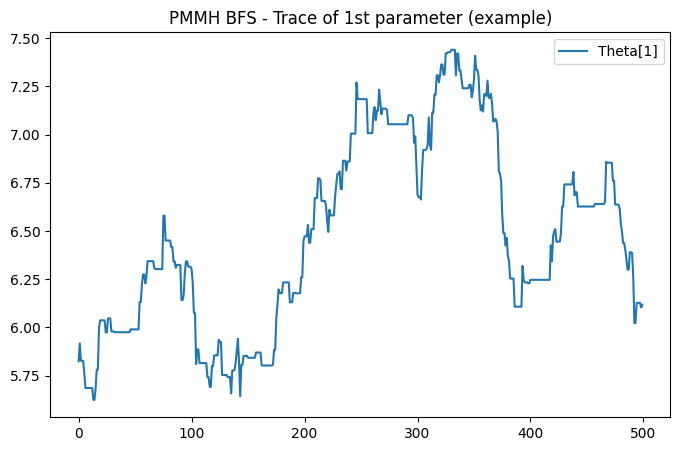

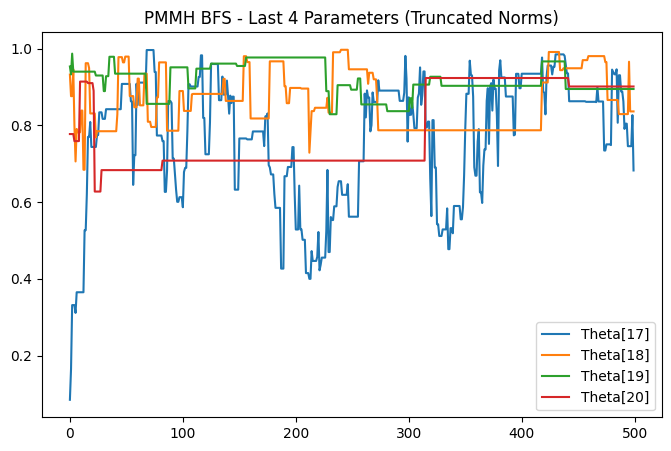

In [11]:
# Plot PMMH (pMCMC) results

plt.figure(figsize=(8,5))
plt.title("PMMH BFS - Trace of 1st parameter (example)")
plt.plot(thetas_pmmh[:, 0], label="Theta[1]")
plt.legend()
plt.show()

# Possibly plot last 4 truncated params
plt.figure(figsize=(8,5))
for i in range(16, 20):
    plt.plot(thetas_pmmh[:, i], label=f"Theta[{i+1}]")
plt.title("PMMH BFS - Last 4 Parameters (Truncated Norms)")
plt.legend()
plt.show()


In [12]:
# SMC^2 results (just printing)
print("SMC^2 param weights sum:", np.sum(param_weights))
print("Some param particle examples:")
for i in range(3):
    print(f"Particle #{i+1}: theta={theta_particles[i]}, weight={param_weights[i]:.3g}")


SMC^2 param weights sum: 1.0000000000000002
Some param particle examples:
Particle #1: theta=[5.04440403 3.92819049 2.34484103 5.5247591  5.75319475 4.98735133
 8.91640781 5.36023393 6.1690179  7.00520638 6.12689662 8.4234967
 9.29492953 2.81365361 6.22616189 5.4132092  0.15835221 0.47374453
 0.79643383 0.07991809], weight=0.05
Particle #2: theta=[5.04440403 3.92819049 2.34484103 5.5247591  5.75319475 4.98735133
 8.91640781 5.36023393 6.1690179  7.00520638 6.12689662 8.4234967
 9.29492953 2.81365361 6.22616189 5.4132092  0.15835221 0.47374453
 0.79643383 0.07991809], weight=0.05
Particle #3: theta=[5.04440403 3.92819049 2.34484103 5.5247591  5.75319475 4.98735133
 8.91640781 5.36023393 6.1690179  7.00520638 6.12689662 8.4234967
 9.29492953 2.81365361 6.22616189 5.4132092  0.15835221 0.47374453
 0.79643383 0.07991809], weight=0.05


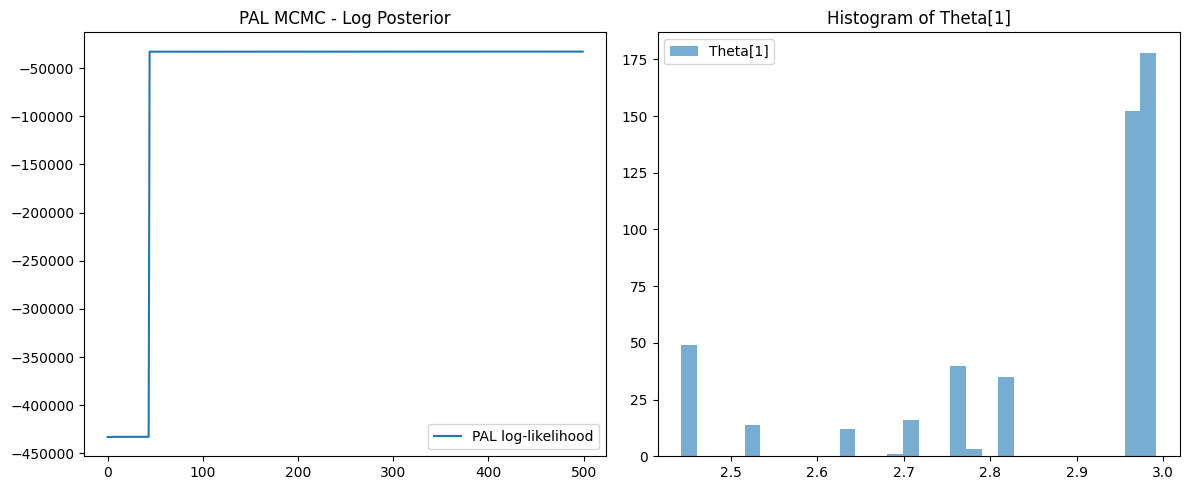

PAL MCMC mean parameters: [2.86553549 3.14823565 6.52040321 5.06735837 3.85104268 3.37867937
 2.17372053 9.01079195 3.73407085 3.93181522 6.86514771 4.7486301
 4.3290143  3.85298827 6.56310594 9.35435102 0.69388632 0.74726462
 0.98085877 0.91454663]


In [13]:
# PAL MCMC results

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(loglikes_pal, label="PAL log-likelihood")
ax[0].set_title("PAL MCMC - Log Posterior")
ax[0].legend()

ax[1].hist(chain_pal[:,0], bins=30, alpha=0.6, label="Theta[1]")
ax[1].set_title("Histogram of Theta[1]")
ax[1].legend()

plt.tight_layout()
plt.show()

mean_pal = np.mean(chain_pal, axis=0)
print("PAL MCMC mean parameters:", mean_pal)
